Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Classes disponíveis no dataset: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


<ipython-input-1-58d175a17173>:45: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
     37/Unknown 32s 550ms/step - accuracy: 0.7137 - loss: 0.5910

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 875ms/step - accuracy: 0.7168 - loss: 0.5849 - val_accuracy: 0.9537 - val_loss: 0.1349
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 913ms/step - accuracy: 0.9423 - loss: 0.1473 - val_accuracy: 0.9537 - val_loss: 0.1261
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 727ms/step - accuracy: 0.9630 - loss: 0.0901 - val_accuracy: 0.9475 - val_loss: 0.1263
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 728ms/step - accuracy: 0.9693 - loss: 0.0817 - val_accuracy: 0.9537 - val_loss: 0.1191
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 46s 876ms/step - accuracy: 0.9890 - loss: 0.0496 - val_accuracy: 0.9444 - val_loss: 0.1253
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 911ms/step - accuracy: 0.9938 - loss: 0.0286 - val_accuracy: 0.9444 - val_loss: 0.1483
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 702ms/step - accuracy: 0.9856 - loss: 0.0392 - val_accuracy: 0.9599 - val_loss: 0.1238
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 683ms/step - accuracy: 0.9927 - loss: 0.0238 - val_accuracy: 0.947

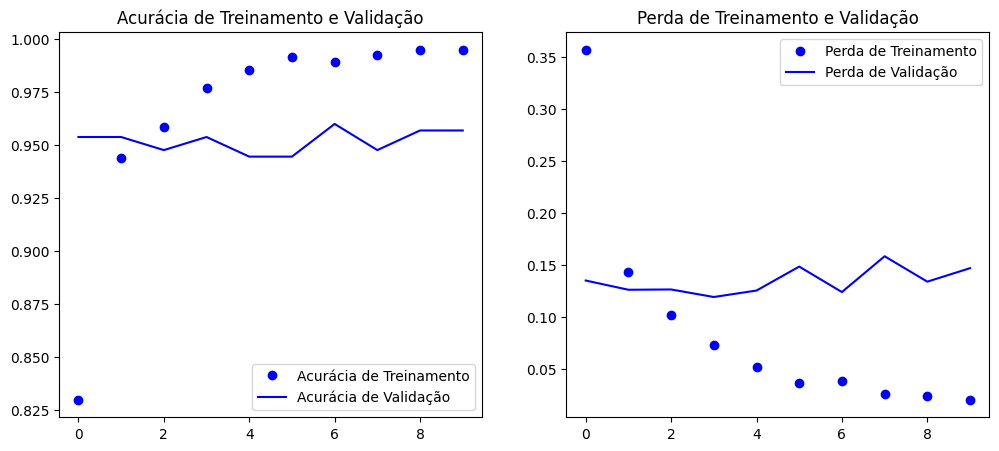

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Carregar o dataset de flores
(raw_train, raw_validation), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Classes do dataset
class_names = metadata.features['label'].names
print("Classes disponíveis no dataset:", class_names)

# Selecionar apenas as classes: Rosas (2) e Girassóis (3)
class_map = {2: "roses", 3: "sunflowers"}  # Mapeamento de índices para as classes desejadas

def filter_classes(image, label):
    """Filtra apenas as imagens das classes rosas e girassóis."""
    return tf.reduce_any(tf.equal(label, list(class_map.keys())))

def map_classes(image, label):
    """Reatribui os rótulos para 0 (roses) e 1 (sunflowers)."""
    new_label = tf.where(label == 2, 0, 1)
    return image, new_label

train_data = raw_train.filter(filter_classes).map(map_classes)
validation_data = raw_validation.filter(filter_classes).map(map_classes)

# Pré-processamento: redimensionar e normalizar as imagens
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150)) / 255.0
    return image, label

train_data = train_data.map(preprocess).batch(32).shuffle(1000)
validation_data = validation_data.map(preprocess).batch(32)

# Construção do modelo com MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Congelar as camadas pré-treinadas

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10
)

# Visualização dos resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Acurácia de Treinamento')
plt.plot(epochs, val_acc, 'b', label='Acurácia de Validação')
plt.title('Acurácia de Treinamento e Validação')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'b', label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.legend()

plt.show()
